# Circuit filter Optimization

## Imports

In [1]:
import sax
import jax
from scipy.constants import c as c_m_s
import jax.numpy as jnp
import scipy.optimize
from ipywidgets import interact
import matplotlib.pyplot as plt
import gdsfactoryplus as gfp

from cspdk.si220 import PDK

## Config

In [2]:
wl0 = 1.55  # [um] Center wavelength
c_um_s = 1e6 * c_m_s  # [um/s] Speed of light
f = c_um_s / wl0  # [Hz] Frequency
df = 100e9  # [Hz] Channel Frequency Spacing
channel_spacing = (c_um_s / (f**2)) * df # [um] Channel Wavelength Spacing
print(f"Channel spacing: {channel_spacing * 1e3:.3f} nm")

wls_nm = 1550 + jnp.array(jnp.arange(8))*0.8
wls = wls_nm / 1e3  # [um]
wl = jnp.linspace(1.50, 1.60, 1001)  # [um]

ng = 3.720  # Group index
neff = 3.185  # Effective index
loss_dB_cm = 3.0 # [dB/cm]
loss_dB_um = loss_dB_cm * 1e-4  # converting dB/cm to dB/m
dL0 = (wl0**2) / (2 * channel_spacing * ng) # [um]
dL_FS = wl0 / neff
# dL0 = dL0 + dL0 * 0.01

print(f"dL={dL0:.3f}um")
print(f"dL_FS={dL_FS:.3f}um")
print(f"{wl}")
print(f"{wls_nm}")

Channel spacing: 0.801 nm
dL=402.947um
dL_FS=0.487um
[1.5    1.5001 1.5002 ... 1.5998 1.5999 1.6   ]
[1550.  1550.8 1551.6 1552.4 1553.2 1554.  1554.8 1555.6]


## Netlist

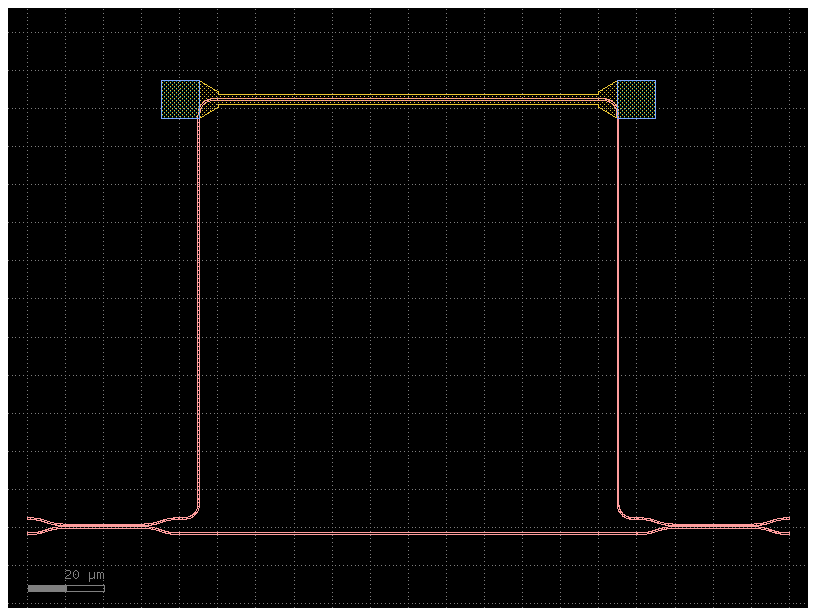

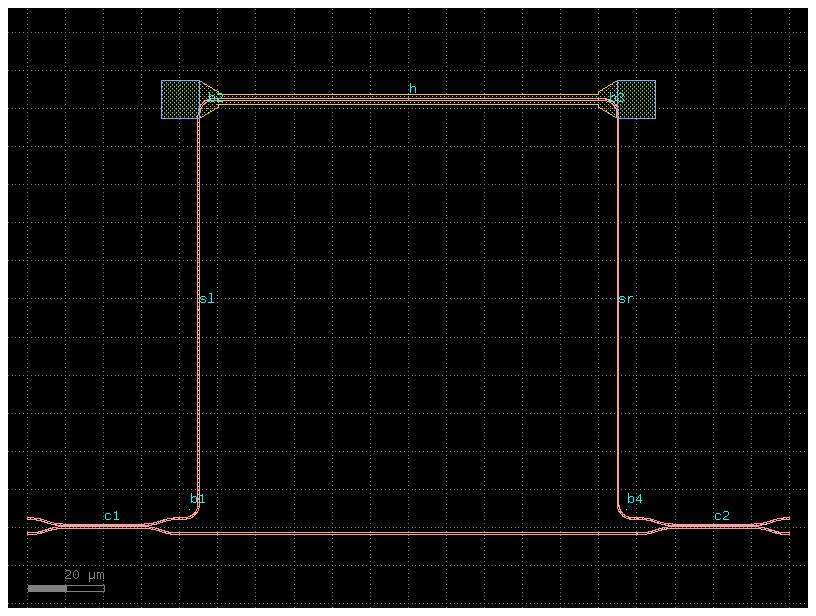

In [3]:
PDK.activate()
gfp.register_cells()
filter = PDK.cells["mzi_heater"]
cell = filter(dL=100)  # add optional lattice arguments here (python pcells only)
netlist = cell.get_netlist(recursive=True)
cell.plot()

In [4]:
#gfp.show(netlist)

In [5]:
netlist

{'mzi_heater_D100': {'nets': ({'p1': 'b1,o1', 'p2': 'c1,o3'},
   {'p1': 'b1,o2', 'p2': 'sl,o1'},
   {'p1': 'b2,o1', 'p2': 'sl,o2'},
   {'p1': 'b2,o2', 'p2': 'h,o1'},
   {'p1': 'b3,o1', 'p2': 'h,o2'},
   {'p1': 'b3,o2', 'p2': 'sr,o1'},
   {'p1': 'b4,o1', 'p2': 'sr,o2'},
   {'p1': 'b4,o2', 'p2': 'c2,o2'},
   {'p1': 'c1,o4', 'p2': 'taper_L10_W0p45_WNone_P_8010e433_40000_m1658,o2'},
   {'p1': 'c2,o1', 'p2': 'taper_L10_W0p45_WNone_P_8010e433_140000_m1658,o2'},
   {'p1': 'straight_L100_CSxs_sc_W0p45_140000_m1658,o1',
    'p2': 'taper_L10_W0p45_WNone_P_8010e433_140000_m1658,o1'},
   {'p1': 'straight_L100_CSxs_sc_W0p45_140000_m1658,o2',
    'p2': 'taper_L10_W0p45_WNone_P_8010e433_40000_m1658,o1'}),
  'instances': {'b1': {'component': 'bend_euler',
    'info': {'length': 8.318,
     'dy': 5,
     'min_bend_radius': 3.53,
     'radius': 5,
     'width': 0.45,
     'route_info_type': 'xs_sc',
     'route_info_length': 8.318,
     'route_info_weight': 8.318,
     'route_info_xs_sc_length': 8.318,


## MZI Circuit

In [6]:
# it's best to construct the circuit outside the wrapping function:
# this makes sure the circuit only needs to be constructed once.
_mzi, _ = sax.circuit(netlist, PDK.models)

# let's now wrap the constructed mzi:

@jax.jit # let's jit it for better performance
def mzi(wl=1.55, dL=dL0):
    
    return _mzi(
        wl=wl, # top-level arguments will be distrubuted to all subcomponents that take that argument.
        # but we can also set settings for a specific subcomponent:
        sr={'length': dL},
        sl={'length': dL},
    )

In [7]:
mzi?

Signature:      mzi(wl=1.55, dL=402.9468521505376)
Call signature: mzi(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function mzi at 0x31845cf40>>
File:           /var/folders/6t/tcyr1gq16g99t9dcztncq_940000gn/T/ipykernel_69774/246461608.py

In [8]:
dL0

402.9468521505376

In [ ]:
@interact(dL=(10, 100))
def show(dL=dL0):
    plt.figure(figsize=(8, 3))
    S = sax.sdict(mzi(wl=wl, dL=dL))
    plt.plot(wl, abs(S["o1", "o3"]) ** 2, label="in0->out0", color="C0")
    plt.plot(wl, abs(S["o1", "o4"]) ** 2, label="in0->out1", ls="--", color="C1")
    plt.ylabel("power")
    plt.grid(True)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.ylim(0.0, 1.0)
    plt.xticks(jnp.round(wls, 4))
    plt.xlim(wls.min(), wls.max())
    plt.xlabel("λ [μm]")
    plt.figlegend(ncol=2)
    plt.show()

interactive(children=(IntSlider(value=100, description='dL', min=10), Output()), _dom_classes=('widget-interac…

## Optimization

We'd like to optimize an MZI such that one of the minima is at 1552.4nm. To do this, we need to define a loss function for the circuit at 1530nm. This function should take the parameters that you want to optimize as positional arguments:

In [44]:
import jax.example_libraries.optimizers as opt
from tqdm.notebook import tqdm, trange

wl_target = 1.5524

@jax.jit
def loss_fn(delta_length):
    S = mzi(
        wl=wl_target,
        dL=delta_length
    )
    return jnp.mean(jnp.abs(S["o1", "o4"]) ** 2)

In [45]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

In [46]:
initial_delta_length = 21.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

Given all this, a single training step can be defined:

In [47]:
def step_fn(step, state):
    params = params_fn(state)
    loss = loss_fn(params)
    grad = grad_fn(params)
    state = update_fn(step, grad, state)
    return loss, state

And we can use this step function to start the training of the MZI:

In [48]:
for step in (
    pb := trange(300)
):  # the first two iterations take a while because the circuit is being jitted...
    loss, state = step_fn(step, state)
    pb.set_postfix(loss=f"{loss:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [49]:
delta_length = params_fn(state)
delta_length

Array(20.91932527, dtype=float64)

Let's see what we've got over a range of wavelengths:

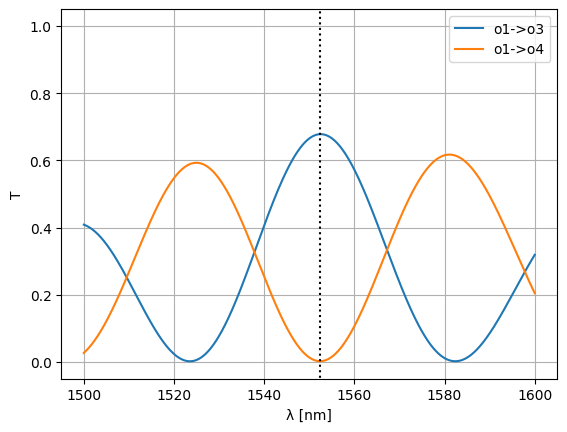

In [50]:
wl = jnp.linspace(1.5, 1.6, 1000)
S = mzi(
    wl=wl,
    dL=delta_length
)
plt.plot(wl * 1e3, abs(S["o1", "o3"]) ** 2, label='o1->o3')
plt.plot(wl * 1e3, abs(S["o1", "o4"]) ** 2, label='o1->o4')
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([wl_target*1e3, wl_target*1e3], [-1, 2], ls=":", color="black")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

We have calculated the delta length of the filter.